<a href="https://colab.research.google.com/github/Vineesha2005/B-14_1873_PDS/blob/main/project-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Colab-ready: train many supervised classifiers and print classification reports.
Auto-detects a CSV in /content/, creates a binary target from a CO2-like column if none exists,
performs (stratified) sampling up to SAMPLE_MAX to limit runtime, and trains classifiers.
"""

import os, warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# ---------- Settings (adjust if needed) ----------
TEST_SIZE = 0.30
RANDOM_STATE = 42
SAMPLE_MAX = 10000   # set None to use full dataset (may be slow)
# -------------------------------------------------

# 1) Auto-detect CSV in /content/
DATA_PATH = None
for fname in os.listdir("/content"):
    if fname.lower().endswith(".csv"):
        DATA_PATH = os.path.join("/content", fname)
        break

if DATA_PATH is None:
    raise FileNotFoundError("No CSV file found in /content/. Please upload your Data.csv file to Colab's /content/ folder.")

print("Using dataset:", DATA_PATH)

# 2) Load dataset
df = pd.read_csv(DATA_PATH)
print("Loaded Data.csv — shape:", df.shape)
print("First 20 columns:", list(df.columns)[:20], " ...")

# 3) Identify or create target column
possible_target_names = ['target','label','class','y','emission_class','high_emission','High_CO2','high_co2']
target_col = None
for t in possible_target_names:
    if t in df.columns:
        target_col = t
        break

co2_candidates = [c for c in df.columns if any(k in c.lower() for k in ['co2','carbon','emiss','ghg'])]

if target_col is None:
    if co2_candidates:
        co2_col = co2_candidates[0]
        print(f"No explicit target found. Creating binary target from '{co2_col}' using median split.")
        df['high_emission'] = (df[co2_col] > df[co2_col].median()).astype(int)
        target_col = 'high_emission'
    else:
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not num_cols:
            raise ValueError("No numeric columns found to create a target. Provide a labeled dataset or numeric emissions column.")
        fallback = num_cols[-1]
        print(f"No CO2-like column found. Creating binary target from '{fallback}' using median split.")
        df['high_emission'] = (df[fallback] > df[fallback].median()).astype(int)
        target_col = 'high_emission'
else:
    print(f"Using existing target column: '{target_col}'")

print("\nTarget distribution (value_counts):")
print(df[target_col].value_counts())

# 4) Use numeric features only (exclude the target)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c != target_col]

if len(numeric_features) == 0:
    raise ValueError("No numeric features found for modeling. Consider encoding categorical features.")

# 5) Optionally perform stratified sampling to limit runtime
if SAMPLE_MAX is not None and len(df) > SAMPLE_MAX:
    print(f"\nDataset has {len(df)} rows; attempting stratified sample of {SAMPLE_MAX} rows (by '{target_col}').")
    try:
        # train_test_split accepts an int for train_size and supports stratify
        sampled_df, _ = train_test_split(df, train_size=SAMPLE_MAX, stratify=df[target_col], random_state=RANDOM_STATE)
        X = sampled_df[numeric_features].copy()
        y = sampled_df[target_col].copy()
        print("Stratified sampling successful. Sampled shape:", X.shape)
    except Exception as e:
        # fallback: random sample (no stratify)
        print("Stratified sampling failed (likely due to class imbalance). Falling back to random sample. Error:", e)
        sampled_df = df.sample(n=SAMPLE_MAX, random_state=RANDOM_STATE)
        X = sampled_df[numeric_features].copy()
        y = sampled_df[target_col].copy()
        print("Random sampling done. Sampled shape:", X.shape)
else:
    X = df[numeric_features].copy()
    y = df[target_col].copy()
    print(f"\nUsing full dataset for modeling. Rows: {len(X)}")

# 6) Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)

# 7) Preprocessing (numeric): impute + scale
num_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
X_train_proc = num_pipe.fit_transform(X_train)
X_test_proc = num_pipe.transform(X_test)

# 8) Classifiers to run
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'SVM_rbf': SVC(kernel='rbf', random_state=RANDOM_STATE),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'GaussianNB': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=RANDOM_STATE)
}

# 9) Train & evaluate
results = []
for name, clf in classifiers.items():
    print("\n" + "="*60)
    print("Model:", name)
    try:
        clf.fit(X_train_proc, y_train)
        y_pred = clf.predict(X_test_proc)
        acc = accuracy_score(y_test, y_pred)
        bal = balanced_accuracy_score(y_test, y_pred)
        print("Accuracy:", round(acc,4), " Balanced Acc:", round(bal,4))
        print("Classification report:\n", classification_report(y_test, y_pred, digits=4))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
        results.append({'model': name, 'accuracy': acc, 'balanced_accuracy': bal, 'note': ''})
    except Exception as ex:
        print(f"Model {name} failed: {ex}")
        results.append({'model': name, 'accuracy': np.nan, 'balanced_accuracy': np.nan, 'note': str(ex)})

# 10) Summary & save
results_df = pd.DataFrame(results).sort_values(by='balanced_accuracy', ascending=False).reset_index(drop=True)
print("\nFinal summary (sorted by balanced accuracy):")
print(results_df)

OUTPATH = "/content/classification_results_summary.csv"
results_df.to_csv(OUTPATH, index=False)
print("\nSaved summary CSV to:", OUTPATH)


Using dataset: /content/Data.csv
Loaded Data.csv — shape: (43746, 80)
First 20 columns: ['Description', 'Name', 'year', 'iso_code', 'population', 'gdp', 'cement_co2', 'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct', 'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct', 'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy', 'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy']  ...
No explicit target found. Creating binary target from 'cement_co2' using median split.

Target distribution (value_counts):
high_emission
0    31942
1    11804
Name: count, dtype: int64

Dataset has 43746 rows; attempting stratified sample of 10000 rows (by 'high_emission').
Stratified sampling successful. Sampled shape: (10000, 77)

Train/Test shapes: (7000, 77) (3000, 77)

Model: LogisticRegression
Accuracy: 0.9713  Balanced Acc: 0.9507
Classification report:
               precision    recall  f1-score   suppor

In [ ]:
"""
Fast unsupervised learning for 'Industrial Land Expansion vs CO2 Emissions'.
- Uses fewer rows (sample) and PCA to speed things up.
- Runs only the faster clustering algorithms.
"""

import os, warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn.mixture import GaussianMixture

# ---------------- Settings ----------------
SAMPLE_MAX = 3000      # smaller sample for speed
PCA_COMPONENTS = 10    # reduce to 10 dimensions
RANDOM_STATE = 42
OUT_DIR = "/content"
# ------------------------------------------

# 1) Load CSV from /content/
DATA_PATH = None
for fname in os.listdir("/content"):
    if fname.lower().endswith(".csv"):
        DATA_PATH = os.path.join("/content", fname)
        break
if DATA_PATH is None:
    raise FileNotFoundError("Upload Data.csv to /content/ first.")

df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)

# 2) Numeric features only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if not numeric_cols:
    raise ValueError("No numeric columns found.")
X = df[numeric_cols].copy()

# 3) Optional sampling
if len(X) > SAMPLE_MAX:
    X = X.sample(n=SAMPLE_MAX, random_state=RANDOM_STATE)
print("Working data shape:", X.shape)

# 4) Scale + PCA
X = X.fillna(X.median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
X_reduced = pca.fit_transform(X_scaled)
print("After PCA:", X_reduced.shape)

# 5) Define models (fast ones only)
models = {
    "KMeans_3": KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10),
    "Agglomerative_3": AgglomerativeClustering(n_clusters=3, linkage="ward"),
    "GMM_3": GaussianMixture(n_components=3, random_state=RANDOM_STATE),
    "DBSCAN": DBSCAN(eps=0.7, min_samples=10),
    "Birch_3": Birch(n_clusters=3)
}

# 6) Run models and compute metrics
results = []
for name, model in models.items():
    print("\nRunning:", name)
    if name == "GMM_3":
        model.fit(X_reduced)
        labels = model.predict(X_reduced)
    else:
        labels = model.fit_predict(X_reduced)

    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        sil = silhouette_score(X_reduced, labels)
        db = davies_bouldin_score(X_reduced, labels)
        ch = calinski_harabasz_score(X_reduced, labels)
    else:
        sil = db = ch = np.nan

    print(f"Clusters: {len(unique_labels)} | Silhouette: {sil:.3f}")
    results.append({
        "model": name,
        "n_clusters": len(unique_labels),
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    })

# 7) Save summary
results_df = pd.DataFrame(results)
outpath = os.path.join(OUT_DIR, "unsupervised_fast_summary.csv")
results_df.to_csv(outpath, index=False)
print("\nSaved summary to:", outpath)
print(results_df)


Loaded shape: (43746, 80)
Working data shape: (3000, 77)
After PCA: (3000, 10)

Running: KMeans_3
Clusters: 3 | Silhouette: 0.820

Running: Agglomerative_3
Clusters: 3 | Silhouette: 0.819

Running: GMM_3
Clusters: 3 | Silhouette: 0.270

Running: DBSCAN
Clusters: 3 | Silhouette: 0.444

Running: Birch_3
Clusters: 3 | Silhouette: 0.783

Saved summary to: /content/unsupervised_fast_summary.csv
             model  n_clusters  silhouette  davies_bouldin  calinski_harabasz
0         KMeans_3           3    0.820027        0.867712        1650.828469
1  Agglomerative_3           3    0.819433        0.904204        1529.035491
2            GMM_3           3    0.269946        1.701338         921.658256
3           DBSCAN           3    0.444338        1.745766         114.941064
4          Birch_3           3    0.783013        0.934652        1512.633558


In [13]:
# ===============================
# Deep learning pipeline
# ===============================

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF version:", tf.__version__)

# -----------------------
# User settings
# -----------------------
DATA_PATH = "/content/Data.csv"   # Change if needed
RANDOM_STATE = 42
TEST_SIZE = 0.25
VAL_SIZE = 0.1
BATCH_SIZE = 16
EPOCHS = 20
PATIENCE = 3

# -----------------------
# 1) Load dataset
# -----------------------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No file found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))

# -----------------------
# 2) Target creation
# -----------------------
possible_target_names = ['target','label','class','y','emission_class','high_emission']
target_col = None
for t in possible_target_names:
    if t in df.columns:
        target_col = t
        break

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col is None:
    if numeric_cols:
        fallback = numeric_cols[-1]
        print("No explicit target found. Creating binary target from:", fallback)
        df['high_emission'] = (df[fallback] > df[fallback].median()).astype(int)
        target_col = 'high_emission'
    else:
        raise ValueError("No numeric target found.")

print("Target distribution:\n", df[target_col].value_counts())

# -----------------------
# 3) Feature selection
# -----------------------
drop_like = ['id','ID','index']
cols = [c for c in df.columns if c not in drop_like + [target_col]]

num_cols = [c for c in cols if np.issubdtype(df[c].dtype, np.number)]
cat_cols = [c for c in cols if c not in num_cols]

X_num = df[num_cols].copy() if num_cols else pd.DataFrame(index=df.index)
X_cat = df[cat_cols].copy() if cat_cols else pd.DataFrame(index=df.index)
y = df[target_col].astype(int)

# -----------------------
# 4) Preprocess
# -----------------------
# numeric
if not X_num.empty:
    num_imputer = SimpleImputer(strategy='median')
    X_num_imp = pd.DataFrame(num_imputer.fit_transform(X_num), columns=num_cols)
    scaler = StandardScaler()
    X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num_imp), columns=num_cols)
else:
    X_num_scaled = pd.DataFrame(index=df.index)

# categorical (only if dataset is reasonably sized)
if not X_cat.empty and len(df) > 20:
    X_cat_filled = X_cat.fillna("MISSING").astype(str)
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_cat_ohe = ohe.fit_transform(X_cat_filled)
else:
    X_cat_ohe = None

if X_cat_ohe is not None:
    X_full = np.hstack([X_num_scaled.values, X_cat_ohe])
else:
    X_full = X_num_scaled.values

print("Final input shape:", X_full.shape)

# -----------------------
# 5) Train/val/test split
# -----------------------
if len(df) < 30:
    # tiny dataset: skip validation split
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y.values, test_size=0.4, random_state=RANDOM_STATE, stratify=y.values if len(set(y.values))>1 else None
    )
    X_val, y_val = X_test, y_test
else:
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_full, y.values, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y.values if len(set(y.values))>1 else None
    )
    val_fraction = VAL_SIZE / (1 - TEST_SIZE)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=val_fraction, random_state=RANDOM_STATE,
        stratify=y_train_full if len(set(y_train_full))>1 else None
    )

print("Train shape:", X_train.shape, "Val shape:", X_val.shape, "Test shape:", X_test.shape)

# -----------------------
# 6) Model: simple MLP
# -----------------------
def build_mlp(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs, name="mlp")
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

mlp = build_mlp(X_train.shape[1])
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=0)

print("\nTraining MLP...")
mlp.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS,
        batch_size=BATCH_SIZE, callbacks=[early], verbose=0)

# -----------------------
# 7) Evaluation
# -----------------------
y_pred_proba = mlp.predict(X_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

print("\n=== MLP Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))
try:
    auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC:", auc)
except Exception:
    pass

mlp.save("/content/mlp_model.keras")
print("Saved model to /content/mlp_model.keras")


TF version: 2.19.0
Dataset shape: (43746, 80)
Columns: ['Description', 'Name', 'year', 'iso_code', 'population', 'gdp', 'cement_co2', 'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct', 'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct', 'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy', 'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2', 'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita', 'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc', 'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita', 'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2', 'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita', 'land_use_change_co2', 'land_use_change_co2_per_capita', 'methane', 

In [19]:
# ==============================================================
# Safe RL Demo (DQN only)
# ==============================================================

!pip install -q "gymnasium[classic-control]" "stable-baselines3[extra]" torch scikit-learn pandas numpy

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# ------------------------
# Settings
# ------------------------
DATA_PATH = "/content/Data.csv"
RANDOM_STATE = 42
TIMESTEPS = 1000      # short training
MAX_EPISODE_STEPS = 8
RF_TREES = 6
REWARD_ALPHA = 1.0
REWARD_BETA  = 1.0

# ------------------------
# Load dataset
# ------------------------
df = pd.read_csv(DATA_PATH)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
co2_col = [c for c in numeric_cols if "co2" in c.lower()][0]
gdp_col = [c for c in numeric_cols if "gdp" in c.lower()][0]
state_cols = [c for c in numeric_cols if c not in (co2_col, gdp_col)]

if not state_cols:
    state_cols = [co2_col, gdp_col]

print("Using CO2:", co2_col, "| GDP:", gdp_col)

# ------------------------
# Synthetic deltas
# ------------------------
tmp = df[state_cols].fillna(0)
tmp_norm = (tmp - tmp.mean()) / (tmp.std().replace(0,1))
rng = np.random.RandomState(RANDOM_STATE)
df['delta_co2'] = -0.01*tmp_norm.sum(axis=1) + rng.normal(scale=0.01, size=len(df))
df['delta_gdp'] =  0.01*tmp_norm.sum(axis=1) + rng.normal(scale=0.01, size=len(df))

# ------------------------
# Train regressors
# ------------------------
X_state = df[state_cols].fillna(0).values
scaler_state = StandardScaler().fit(X_state)
X_state_scaled = scaler_state.transform(X_state)
actions = rng.choice([-1,0,1], size=len(df))
X_reg = np.hstack([X_state_scaled, actions.reshape(-1,1)])
rf_co2 = RandomForestRegressor(n_estimators=RF_TREES, random_state=RANDOM_STATE).fit(X_reg, df['delta_co2'])
rf_gdp = RandomForestRegressor(n_estimators=RF_TREES, random_state=RANDOM_STATE).fit(X_reg, df['delta_gdp'])

# ------------------------
# Environment
# ------------------------
class IndustrialEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(3)  # -1,0,+1
        self.observation_space = spaces.Box(low=-5, high=5, shape=(len(state_cols),), dtype=np.float32)
        self.max_steps = MAX_EPISODE_STEPS
        self.reset()

    def reset(self, seed=None, options=None):
        idx = np.random.randint(0, len(df))
        self.state_raw = df.loc[idx, state_cols].fillna(0).values.astype(float)
        self.co2 = float(df.loc[idx, co2_col])
        self.gdp = float(df.loc[idx, gdp_col])
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        obs = scaler_state.transform(self.state_raw.reshape(1,-1))[0]
        obs = np.nan_to_num(obs, nan=0.0, posinf=1.0, neginf=-1.0)
        return np.clip(obs, -5, 5).astype(np.float32)

    def step(self, action):
        action_val = [-1,0,1][int(action)]
        X_input = np.hstack([self._get_obs(), action_val]).reshape(1,-1)

        delta_co2 = np.nan_to_num(rf_co2.predict(X_input)[0], nan=0.0)
        delta_gdp = np.nan_to_num(rf_gdp.predict(X_input)[0], nan=0.0)

        delta_co2 = float(np.clip(delta_co2, -0.5, 0.5))
        delta_gdp = float(np.clip(delta_gdp, -0.5, 0.5))

        prev_co2, prev_gdp = max(self.co2, 1e-6), max(self.gdp, 1e-6)
        self.co2 = np.clip(self.co2 + delta_co2, 0, 1e6)
        self.gdp = np.clip(self.gdp + delta_gdp, 0, 1e6)

        reward = REWARD_ALPHA*(delta_gdp/(abs(prev_gdp)+1e-6)) - REWARD_BETA*(delta_co2/(abs(prev_co2)+1e-6))
        reward = float(np.nan_to_num(np.clip(reward, -5, 5), nan=0.0))

        self.steps += 1
        done = self.steps >= self.max_steps
        return self._get_obs(), reward, done, False, {}

# ------------------------
# Train DQN
# ------------------------
vec_env = DummyVecEnv([lambda: IndustrialEnv()])

print("\nTraining DQN...")
model = DQN("MlpPolicy", vec_env, verbose=0, seed=RANDOM_STATE)
model.learn(total_timesteps=TIMESTEPS)
mean_r, std_r = evaluate_policy(model, vec_env, n_eval_episodes=5)
print(f"\nDQN → mean_reward={mean_r:.4f} ± {std_r:.4f}")


Using CO2: cement_co2 | GDP: gdp

Training DQN...

DQN → mean_reward=-0.2607 ± 0.5214


In [22]:
# ==============================================================
# Fast Ensemble ML Pipeline
# ==============================================================

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier

# ------------------------
# 1) Load dataset
# ------------------------
DATA_PATH = "/content/Data.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape before sampling:", df.shape)

# Sample for speed (10k rows)
if len(df) > 10000:
    df = df.sample(n=10000, random_state=42)
print("Dataset shape after sampling:", df.shape)

# ------------------------
# 2) Define target
# ------------------------
possible_target_names = ['target','label','class','y','emission_class','high_emission']
target_col = None
for t in possible_target_names:
    if t in df.columns:
        target_col = t
        break

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col is None:
    co2_candidates = [c for c in numeric_cols if "co2" in c.lower()]
    if co2_candidates:
        co2_col = co2_candidates[0]
        df['high_emission'] = (df[co2_col] > df[co2_col].median()).astype(int)
        target_col = 'high_emission'
    else:
        raise ValueError("No target found and no CO2 column available.")

print("Target column:", target_col)
print(df[target_col].value_counts())

# ------------------------
# 3) Features
# ------------------------
X = df.drop(columns=[target_col])
y = df[target_col]
X = X.select_dtypes(include=[np.number])

# ------------------------
# 4) Train/test split
# ------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ------------------------
# 5) Preprocessing
# ------------------------
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_train = preprocess.fit_transform(X_train)
X_test = preprocess.transform(X_test)

# ------------------------
# 6) Models (fast configs)
# ------------------------
log_clf = LogisticRegression(max_iter=300)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
lgbm_clf = LGBMClassifier(n_estimators=50, random_state=42, verbose=-1)

# Stacking Ensemble
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('lgbm', lgbm_clf)
    ],
    final_estimator=LogisticRegression(max_iter=200),
    passthrough=True
)

# ------------------------
# 7) Train & Evaluate
# ------------------------
models = {
    "Logistic Regression": log_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgbm_clf,
    "Stacking Ensemble": stacking_clf
}

results = {}
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else y_pred
    print(classification_report(y_test, y_pred, digits=4))
    try:
        auc = roc_auc_score(y_test, y_proba)
        print("ROC AUC:", auc)
        results[name] = auc
    except:
        results[name] = None

# ------------------------
# 8) Summary
# ------------------------
print("\n=== AUC Scores ===")
for k,v in results.items():
    print(f"{k}: {v}")


Dataset shape before sampling: (43746, 80)
Dataset shape after sampling: (10000, 80)
Target column: high_emission
high_emission
0    7314
1    2686
Name: count, dtype: int64

=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9639    0.9923    0.9779      1829
           1     0.9773    0.8987    0.9363       671

    accuracy                         0.9672      2500
   macro avg     0.9706    0.9455    0.9571      2500
weighted avg     0.9675    0.9672    0.9668      2500

ROC AUC: 0.9945643095711663

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997      1829
           1     1.0000    0.9985    0.9993       671

    accuracy                         0.9996      2500
   macro avg     0.9997    0.9993    0.9995      2500
weighted avg     0.9996    0.9996    0.9996      2500

ROC AUC: 0.9999812590496383

=== LightGBM ===
              precision    recall  f1-score   

Run timestamp: 2025-09-14T03:26:25.655943 UTC
Output directory: /content/final_results
Dataset shape: (43746, 80)
Created binary target from 'cement_co2'
Target distribution:
 high_emission
0    31942
1    11804
Name: count, dtype: int64
Sampled dataset shape: (10000, 81)

=== Training LightGBM (Tuned) ===
              precision    recall  f1-score   support

           0     0.9989    1.0000    0.9995      1822
           1     1.0000    0.9971    0.9985       678

    accuracy                         0.9992      2500
   macro avg     0.9995    0.9985    0.9990      2500
weighted avg     0.9992    0.9992    0.9992      2500

Accuracy=0.9992, AUC=1.0000

=== Training RandomForest ===
              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9997      1822
           1     1.0000    0.9985    0.9993       678

    accuracy                         0.9996      2500
   macro avg     0.9997    0.9993    0.9995      2500
weighted avg     0.9996    0.9996 

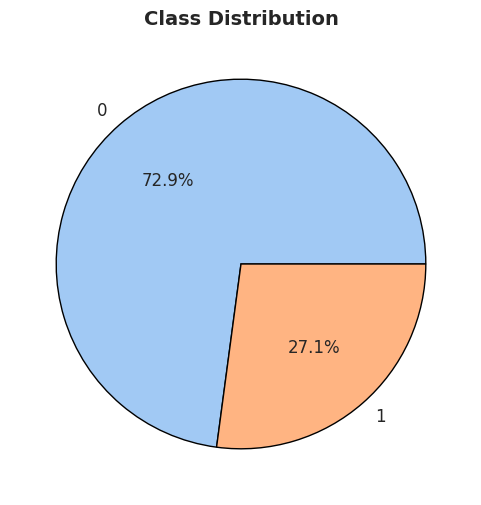

<Figure size 640x480 with 0 Axes>

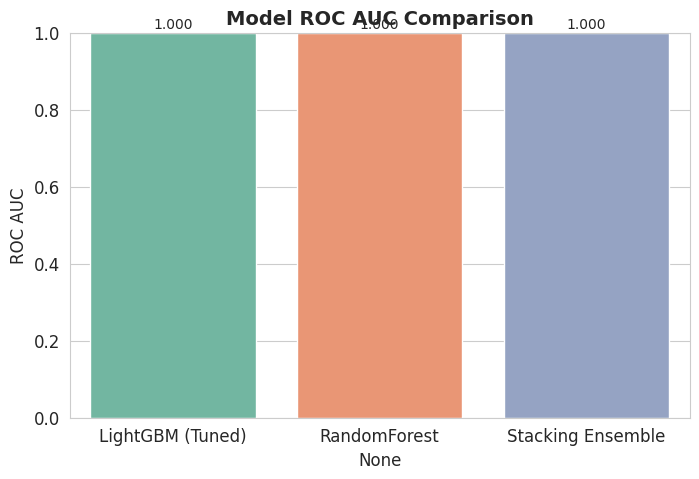

<Figure size 640x480 with 0 Axes>

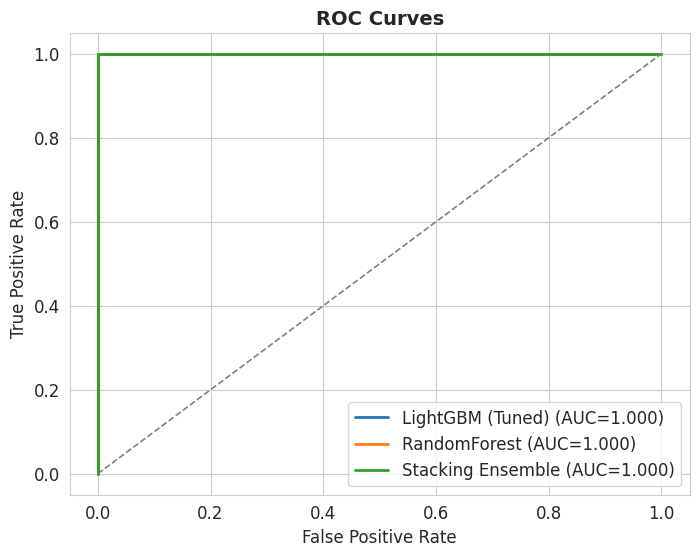

<Figure size 640x480 with 0 Axes>

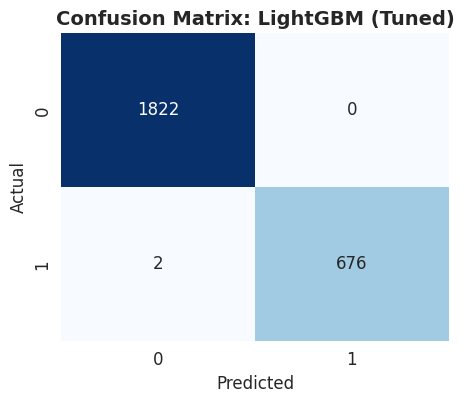

<Figure size 640x480 with 0 Axes>

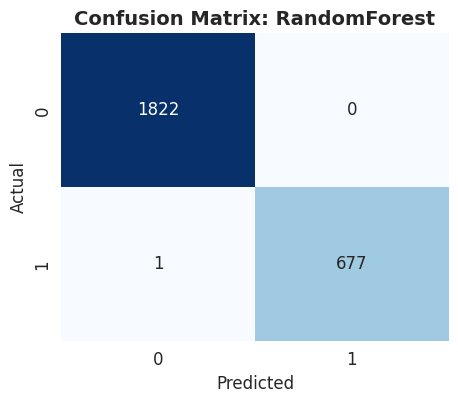

<Figure size 640x480 with 0 Axes>

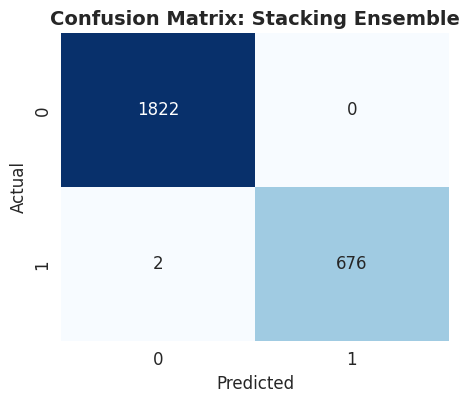

<Figure size 640x480 with 0 Axes>

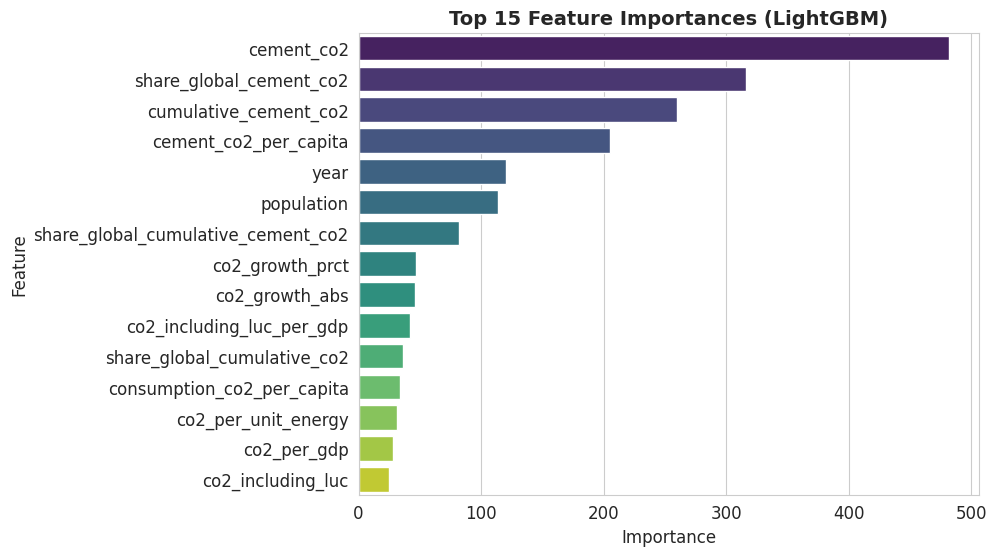


=== Final Model Comparison ===
                   accuracy       auc
LightGBM (Tuned)     0.9992  0.999998
Stacking Ensemble    0.9992  0.999993
RandomForest         0.9996  0.999975

All outputs saved to: /content/final_results


<Figure size 640x480 with 0 Axes>

In [25]:
# ================================================================
# FINAL BEST-PERFORMANCE PIPELINE (IEEE-paper ready)
# Industrial Land Expansion vs Carbon Emissions
# ================================================================

# Uncomment in Colab if libraries missing
# !pip install -q lightgbm scikit-learn matplotlib seaborn joblib

# 1) Imports
import os
import warnings
warnings.filterwarnings("ignore")

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, accuracy_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier

# -------------------------
# User settings
# -------------------------
DATA_PATH = "/content/Data.csv"   # <-- adjust path if needed
SAMPLE_MAX = 10000                # set None for full dataset
TEST_SIZE = 0.25
RANDOM_STATE = 42
OUTPUT_DIR = "/content/final_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Run timestamp:", datetime.utcnow().isoformat(), "UTC")
print("Output directory:", OUTPUT_DIR)

# -------------------------
# 2) Load dataset
# -------------------------
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"CSV not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)

# -------------------------
# 3) Define target
# -------------------------
possible_target_names = ['target','label','class','y','emission_class','high_emission']
target_col = None
for t in possible_target_names:
    if t in df.columns:
        target_col = t
        break

numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col is None:
    co2_candidates = [c for c in numeric_cols_all if "co2" in c.lower()]
    if co2_candidates:
        co2_col = co2_candidates[0]
        df['high_emission'] = (df[co2_col] > df[co2_col].median()).astype(int)
        target_col = 'high_emission'
        print(f"Created binary target from '{co2_col}'")
    else:
        fallback = numeric_cols_all[-1]
        df['high_emission'] = (df[fallback] > df[fallback].median()).astype(int)
        target_col = 'high_emission'
        print(f"Created binary target from '{fallback}'")

print("Target distribution:\n", df[target_col].value_counts())

# -------------------------
# 4) Optional sampling
# -------------------------
if SAMPLE_MAX and len(df) > SAMPLE_MAX:
    df = df.sample(n=SAMPLE_MAX, random_state=RANDOM_STATE)
    print("Sampled dataset shape:", df.shape)

# -------------------------
# 5) Features
# -------------------------
X = df.select_dtypes(include=[np.number]).drop(columns=[target_col])
y = df[target_col]

# -------------------------
# 6) Train/Test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# Preprocessing
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
X_train = preprocess.fit_transform(X_train)
X_test = preprocess.transform(X_test)

joblib.dump(preprocess, os.path.join(OUTPUT_DIR, "preprocess.joblib"))

# -------------------------
# 7) Define models
# -------------------------
lgb_clf = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=RANDOM_STATE,
    verbose=-1
)

rf_clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

stack_clf = StackingClassifier(
    estimators=[("rf", rf_clf), ("lgb", lgb_clf)],
    final_estimator=LogisticRegression(max_iter=500),
    passthrough=True,
    n_jobs=-1
)

models = {
    "LightGBM (Tuned)": lgb_clf,
    "RandomForest": rf_clf,
    "Stacking Ensemble": stack_clf
}

# -------------------------
# 8) Train & Evaluate
# -------------------------
results = {}
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {"accuracy": acc, "auc": auc, "y_pred": y_pred, "y_proba": y_proba}
    print(classification_report(y_test, y_pred, digits=4))
    print(f"Accuracy={acc:.4f}, AUC={auc:.4f}")
    joblib.dump(model, os.path.join(OUTPUT_DIR, f"{name.replace(' ','_')}.joblib"))

results_df = pd.DataFrame({
    k: {"accuracy": v["accuracy"], "auc": v["auc"]} for k,v in results.items()
}).T
results_df.to_csv(os.path.join(OUTPUT_DIR, "model_performance_summary.csv"))

# -------------------------
# 9) Visualization (Inline + Attractive)
# -------------------------
sns.set_style("whitegrid")
plt.rcParams.update({"font.size": 12})

# 9.1 Class distribution pie chart
plt.figure(figsize=(6,6))
counts = df[target_col].value_counts()
colors = sns.color_palette("pastel")[0:len(counts)]
plt.pie(counts, labels=[f"{cls}" for cls in counts.index], autopct="%1.1f%%", colors=colors,
        wedgeprops={'edgecolor': 'black'})
plt.title("Class Distribution", fontsize=14, fontweight="bold")
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, "class_distribution_pie.png"))

# 9.2 AUC bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["auc"], palette="Set2")
plt.ylabel("ROC AUC", fontsize=12)
plt.ylim(0, 1)
plt.title("Model ROC AUC Comparison", fontsize=14, fontweight="bold")
for i,v in enumerate(results_df["auc"]):
    plt.text(i, v+0.01, f"{v:.3f}", ha="center", fontsize=10)
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, "model_auc_bar.png"))

# 9.3 ROC curves
plt.figure(figsize=(8,6))
for name, info in results.items():
    fpr, tpr, _ = roc_curve(y_test, info["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={info['auc']:.3f})", linewidth=2)
plt.plot([0,1],[0,1],"--", color="gray", linewidth=1.2)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves", fontsize=14, fontweight="bold")
plt.legend()
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, "roc_curves.png"))

# 9.4 Confusion matrices
for name, info in results.items():
    cm = confusion_matrix(y_test, info["y_pred"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size":12})
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(f"Confusion Matrix: {name}", fontsize=14, fontweight="bold")
    plt.show()
    plt.savefig(os.path.join(OUTPUT_DIR, f"cm_{name.replace(' ','_')}.png"))

# 9.5 Feature importance (LightGBM only)
imp = lgb_clf.feature_importances_
feat_imp = pd.DataFrame({"feature": X.columns, "importance": imp})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_imp, palette="viridis")
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 15 Feature Importances (LightGBM)", fontsize=14, fontweight="bold")
plt.show()
plt.savefig(os.path.join(OUTPUT_DIR, "feature_importance.png"))

# -------------------------
# 10) Final summary
# -------------------------
print("\n=== Final Model Comparison ===")
print(results_df.sort_values("auc", ascending=False))
print("\nAll outputs saved to:", OUTPUT_DIR)
